Задачи:

1. Для "Промо декабрь 2019" (promo_id=39) рассчитать прогноз промо продаж "sum_sale" для всех пересечений good_id/ship_store_id
2. Выделить топ 3 пересечений good_group_cod/ship_store_id с максимальной ошибкой. Проанализировать причины.
3. Сформулировать предложения по улучшению качества прогноза.

Описание данных:

- good_id - идентификатор товара;
- ship_store_id - идентификатор магазина;
- holiday - оличество праздничных дней в промо;
- promo_groups - группа промо (по сопоставимости);
- promo_id - идентификатор промо;
- sum_sale - продажи за период промо;
- discount - скидка на периоде промо;
- avg_presale - средние продажи на периоде предшествующем промо;
- sum_presale - сумма продаж  на периоде предшествующем промо;
- max_presale - максимальные дневные продажи на периоде предшествующем промо;
- min_presale - минимальные дневные продажи на периоде предшествующем промо;
- reg_price - регулярная цена (без скидки);
- promo_price - промо цена;
- TV - флаг наличия ТВ рекламы.

## 1. Подготовка данных

В этом разделе я импортирую бибилотеки, подготавливаю и разбиваю данные на train, valid, test.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.txt', sep=";", decimal=',')
goods_dict = pd.read_excel('goods_dict.xlsx')


df['promo_price'] = df['promo_price'].astype('int')

df.columns = ['good_id_cat' , 'ship_store_id_cat', 'holiday',  'promo_groups_cat', 'promo_id_cat', 'sum_sale', 
               'discount', 'avg_presale', 'sum_presale',  'max_presale', 'min_presale', 'reg_price', 'promo_price', 'TV_cat']

In [2]:
df.head()

,good_id_cat,ship_store_id_cat,holiday,promo_groups_cat,promo_id_cat,sum_sale,discount,avg_presale,sum_presale,max_presale,min_presale,reg_price,promo_price,TV_cat
0,166035,25,3,21,78,2,20,0.0312,1,1,0,2999,2399,0
1,154575,29,3,3,65,22,25,0.4062,13,4,0,1599,1199,0
2,134788,5,0,10,77,0,0,0.0000,0,0,0,8299,8299,0
3,176690,5,0,16,4,8,29,0.0937,3,1,0,1399,999,0
4,149690,57,1,6,50,39,33,0.4516,14,4,0,299,199,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506242 entries, 0 to 506241
Data columns (total 14 columns):
good_id_cat          506242 non-null int64
ship_store_id_cat    506242 non-null int64
holiday              506242 non-null int64
promo_groups_cat     506242 non-null int64
promo_id_cat         506242 non-null int64
sum_sale             506242 non-null int64
discount             506242 non-null int64
avg_presale          506242 non-null float64
sum_presale          506242 non-null int64
max_presale          506242 non-null int64
min_presale          506242 non-null int64
reg_price            506242 non-null int64
promo_price          506242 non-null int32
TV_cat               506242 non-null int64
dtypes: float64(1), int32(1), int64(12)
memory usage: 52.1 MB


In [4]:
test = df.query('promo_id_cat == 39')
train = df.query('promo_id_cat != 39')

f_test = test.drop('sum_sale',axis=1)
t_test = test['sum_sale']
f_train = train.drop('sum_sale',axis=1)
t_train = train['sum_sale']

f_test.shape[0], t_test.shape[0], f_train.shape[0], t_train.shape[0]

(35380, 35380, 470862, 470862)

In [5]:
f_train, f_valid, t_train, t_valid = train_test_split(f_train, t_train, test_size=0.2, random_state=1)

cat_features = [c for c, col in enumerate(f_train.columns) if '_cat' in col]
cv =KFold(random_state=1, n_splits=5)

## 2. Обучение моделей

Здесь я обучаю разные модели и сравниваю качество. Параметры для моделей подбирались через GridSearch. параметры подбирались на valid выборке, тестовые данные не рассматривались.

In [6]:
final_result = pd.DataFrame(columns = ['model', 'mae_valid'])

In [7]:
%%time

model_forest = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=1)
model_forest.fit(f_train, t_train)
predictions_forest_valid = model_forest.predict(f_valid)
mae_forest_valid = mean_absolute_error(t_valid, predictions_forest_valid)

final_result.loc[0,'model'] = 'RandomForestRegressor'
final_result.loc[0,'mae_valid'] = mae_forest_valid

Wall time: 56.6 s


In [8]:
%%time

model_lr = LinearRegression()
model_lr.fit(f_train, t_train)
predictions_lr = model_lr.predict(f_valid)
mae_lr = mean_absolute_error(t_valid, predictions_lr)

final_result.loc[1,'model'] = 'LinearRegression'
final_result.loc[1,'mae_valid'] = mae_lr

Wall time: 232 ms


In [9]:
%%time

gbm = lgb.LGBMRegressor(learning_rate =  0.1, max_depth =  20, n_estimators = 200, num_leaves = 50)
gbm.fit(f_train, t_train, categorical_feature=cat_features)
predictions_gbm = gbm.predict(f_valid)
mae_gbm = mean_absolute_error(t_valid, predictions_gbm)

final_result.loc[2,'model'] = 'LGBMRegressor'
final_result.loc[2,'mae_valid'] = mae_gbm

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 12]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Wall time: 17.6 s


In [10]:
%%time

model_cb = CatBoostRegressor(learning_rate = 0.1, depth= 10,  n_estimators = 500, l2_leaf_reg = 0.1, eval_metric = 'MAE', verbose = True)
model_cb.fit(f_train, t_train)
predictions_cb = model_cb.predict(f_valid)
mae_cb = mean_absolute_error(t_valid, predictions_cb)

final_result.loc[3,'model'] = 'CatBoostRegressor'
final_result.loc[3,'mae_valid'] = mae_cb

0:	learn: 13.0246458	total: 201ms	remaining: 1m 40s
1:	learn: 12.3739106	total: 342ms	remaining: 1m 25s
2:	learn: 11.8297107	total: 492ms	remaining: 1m 21s
3:	learn: 11.4106171	total: 632ms	remaining: 1m 18s
4:	learn: 10.9700875	total: 790ms	remaining: 1m 18s
5:	learn: 10.5810930	total: 936ms	remaining: 1m 17s
6:	learn: 10.2862844	total: 1.09s	remaining: 1m 16s
7:	learn: 10.0076539	total: 1.23s	remaining: 1m 15s
8:	learn: 9.7694391	total: 1.38s	remaining: 1m 15s
9:	learn: 9.5629282	total: 1.52s	remaining: 1m 14s
10:	learn: 9.3672283	total: 1.67s	remaining: 1m 14s
11:	learn: 9.2262474	total: 1.81s	remaining: 1m 13s
12:	learn: 9.0796812	total: 1.96s	remaining: 1m 13s
13:	learn: 8.9403081	total: 2.1s	remaining: 1m 12s
14:	learn: 8.8106364	total: 2.25s	remaining: 1m 12s
15:	learn: 8.7008089	total: 2.4s	remaining: 1m 12s
16:	learn: 8.6154937	total: 2.54s	remaining: 1m 12s
17:	learn: 8.5310556	total: 2.68s	remaining: 1m 11s
18:	learn: 8.4350157	total: 2.83s	remaining: 1m 11s
19:	learn: 8.351

162:	learn: 6.4697646	total: 24.2s	remaining: 50s
163:	learn: 6.4647064	total: 24.3s	remaining: 49.8s
164:	learn: 6.4615668	total: 24.5s	remaining: 49.7s
165:	learn: 6.4551396	total: 24.6s	remaining: 49.5s
166:	learn: 6.4529422	total: 24.8s	remaining: 49.4s
167:	learn: 6.4467790	total: 24.9s	remaining: 49.3s
168:	learn: 6.4403757	total: 25.1s	remaining: 49.1s
169:	learn: 6.4384068	total: 25.2s	remaining: 49s
170:	learn: 6.4354715	total: 25.4s	remaining: 48.8s
171:	learn: 6.4275270	total: 25.5s	remaining: 48.7s
172:	learn: 6.4240651	total: 25.7s	remaining: 48.5s
173:	learn: 6.4162564	total: 25.8s	remaining: 48.4s
174:	learn: 6.4112188	total: 26s	remaining: 48.2s
175:	learn: 6.3996019	total: 26.1s	remaining: 48.1s
176:	learn: 6.3957572	total: 26.3s	remaining: 47.9s
177:	learn: 6.3933403	total: 26.4s	remaining: 47.8s
178:	learn: 6.3861872	total: 26.6s	remaining: 47.6s
179:	learn: 6.3796487	total: 26.7s	remaining: 47.5s
180:	learn: 6.3774667	total: 26.9s	remaining: 47.3s
181:	learn: 6.3736

322:	learn: 5.8788366	total: 47.5s	remaining: 26s
323:	learn: 5.8783518	total: 47.6s	remaining: 25.9s
324:	learn: 5.8760636	total: 47.8s	remaining: 25.7s
325:	learn: 5.8742099	total: 47.9s	remaining: 25.6s
326:	learn: 5.8713317	total: 48s	remaining: 25.4s
327:	learn: 5.8680846	total: 48.2s	remaining: 25.3s
328:	learn: 5.8668218	total: 48.3s	remaining: 25.1s
329:	learn: 5.8636511	total: 48.5s	remaining: 25s
330:	learn: 5.8612631	total: 48.6s	remaining: 24.8s
331:	learn: 5.8592048	total: 48.8s	remaining: 24.7s
332:	learn: 5.8584484	total: 48.9s	remaining: 24.5s
333:	learn: 5.8567572	total: 49s	remaining: 24.4s
334:	learn: 5.8544877	total: 49.2s	remaining: 24.2s
335:	learn: 5.8519738	total: 49.3s	remaining: 24.1s
336:	learn: 5.8460832	total: 49.5s	remaining: 23.9s
337:	learn: 5.8444516	total: 49.6s	remaining: 23.8s
338:	learn: 5.8424468	total: 49.8s	remaining: 23.6s
339:	learn: 5.8401522	total: 49.9s	remaining: 23.5s
340:	learn: 5.8390510	total: 50s	remaining: 23.3s
341:	learn: 5.8359622	

482:	learn: 5.5262638	total: 1m 15s	remaining: 2.65s
483:	learn: 5.5250366	total: 1m 15s	remaining: 2.5s
484:	learn: 5.5237453	total: 1m 15s	remaining: 2.35s
485:	learn: 5.5212236	total: 1m 16s	remaining: 2.19s
486:	learn: 5.5189330	total: 1m 16s	remaining: 2.03s
487:	learn: 5.5168237	total: 1m 16s	remaining: 1.88s
488:	learn: 5.5151407	total: 1m 16s	remaining: 1.72s
489:	learn: 5.5130110	total: 1m 16s	remaining: 1.57s
490:	learn: 5.5094842	total: 1m 16s	remaining: 1.41s
491:	learn: 5.5075646	total: 1m 17s	remaining: 1.25s
492:	learn: 5.5037338	total: 1m 17s	remaining: 1.1s
493:	learn: 5.5023048	total: 1m 17s	remaining: 942ms
494:	learn: 5.4978776	total: 1m 17s	remaining: 785ms
495:	learn: 5.4941305	total: 1m 17s	remaining: 629ms
496:	learn: 5.4925401	total: 1m 18s	remaining: 472ms
497:	learn: 5.4917512	total: 1m 18s	remaining: 315ms
498:	learn: 5.4875579	total: 1m 18s	remaining: 157ms
499:	learn: 5.4865681	total: 1m 18s	remaining: 0us
Wall time: 1min 20s


In [11]:
predictions_forest_test = model_forest.predict(f_test)
mae_forest_test = mean_absolute_error(t_test, predictions_forest_test)

predictions_lr = model_lr.predict(f_test)
mae_lr = mean_absolute_error(t_test, predictions_lr)

predictions_gbm = gbm.predict(f_test)
mae_gbm = mean_absolute_error(t_test, predictions_gbm)

predictions_cb = model_cb.predict(f_test)
mae_cb = mean_absolute_error(t_test, predictions_cb)

final_result['mae_test'] = [mae_forest_test , mae_lr, mae_gbm, mae_cb]
final_result['diff, %'] = - (final_result['mae_test'] / final_result['mae_valid'] - 1) * 100

final_result.sort_values('mae_test', ascending = True)


,model,mae_valid,mae_test,"diff, %"
2,LGBMRegressor,4.88054,6.931140,-42.0158
3,CatBoostRegressor,5.96791,8.121661,-36.0888
0,RandomForestRegressor,7.29503,8.210622,-12.551
1,LinearRegression,10.5779,9.785401,7.49196


Вывод: выбираем CatBoostRegressor потому что несмотря на бОльшую ошибку относительно LGBMRegressor, его качество стабильнее чем у LGBMRegressor.

## Задание 1.

Для "Промо декабрь 2019" (promo_id=39) рассчитать прогноз промо продаж "sum_sale" для всех пересечений good_id/ship_store_id

In [12]:
test['Predictions'] = predictions_cb


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
pivot_table_1 = test.pivot_table(index=['good_id_cat', 'ship_store_id_cat'],
                                 values=['Predictions', 'sum_sale'], aggfunc='median')
pivot_table_1

Predictions  sum_sale
good_id_cat ship_store_id_cat                       
20860       2                    12.984329        10
            5                    12.785436        17
            6                    15.486442         9
            9                    15.767088         8
            10                    8.558977         6
...                                    ...       ...
202637      69                    3.179437         1
            121                   5.676879         9
            126                   1.741972         1
            156                   2.548294         8
            167                   3.650460         2

[35380 rows x 2 columns]

Согласно рассчетам выше, CatBoostRegressor должен ошибаться в среднем примерно на 8 единиц проданного товара.

## Задание 2.

Выделить топ 3 пересечений good_group_cod/ship_store_id с максимальной ошибкой. Проанализировать причины.

In [14]:
goods_dict['good_id_cat'] = goods_dict['good_id']
df1 = test.merge(goods_dict, on='good_id_cat')
df1['mae'] = abs(df1['sum_sale']  - df1['Predictions'])

In [15]:
pivot_table_2 = df1.pivot_table(index=['good_group_cod', 'ship_store_id_cat'], values=['mae','Predictions', 'sum_sale'], 
                                aggfunc='max').sort_values('mae', ascending = False).head(3)
pivot_table_2

Predictions          mae  sum_sale
good_group_cod ship_store_id_cat                                    
189            66                  367.842914  1750.157086      2118
               112                 169.991194   821.008806       991
               146                 209.697213   593.302787       803

## Задание 3. Анализ причин и улучшение прогноза

Расширим предыдущую таблицу до 10 значений и посмотрим на строки с ними

In [16]:
pivot_table_2 = df1.pivot_table(index=['good_group_cod', 'ship_store_id_cat'], values=['mae','Predictions', 'sum_sale'], 
                                aggfunc='max').sort_values('mae', ascending = False).head(10)
pivot_table_2

Predictions          mae  sum_sale
good_group_cod ship_store_id_cat                                    
189            66                  367.842914  1750.157086      2118
               112                 169.991194   821.008806       991
               146                 209.697213   593.302787       803
101            66                  309.294094   578.499875       822
189            54                  156.488715   524.511285       681
               56                  225.116480   522.883520       748
               98                  147.254544   416.745456       564
230            60                 2084.614408   404.614408      1680
101            56                  213.015016   403.086979       576
               45                  284.424138   391.238208       584

In [17]:
df.query('sum_sale == 2118 or sum_sale == 991 or sum_sale == 803 or sum_sale == 1680 or sum_sale == 564  or sum_sale == 822  or sum_sale == 584  or sum_sale == 748')

,good_id_cat,ship_store_id_cat,holiday,promo_groups_cat,promo_id_cat,sum_sale,discount,avg_presale,sum_presale,max_presale,min_presale,reg_price,promo_price,TV_cat
58677,30439,67,2,2,90,584,45,2.7812,89,7,0,89,49,0
67765,30439,146,0,12,39,803,45,0.8750,28,4,0,89,49,0
76251,30439,56,0,12,39,748,45,1.6875,54,8,0,89,49,0
129449,30439,98,0,12,39,564,45,0.1562,5,1,0,89,49,0
156685,98275,66,0,12,39,822,45,0.6875,22,4,0,199,109,0
271767,98275,45,0,12,39,584,45,0.3125,10,2,0,199,109,0
315418,165003,60,0,12,39,1680,20,40.2187,1287,100,3,139,111,1
345994,147614,69,0,10,76,584,35,4.8125,154,13,0,599,390,1
381302,30439,66,0,12,39,2118,45,0.6562,21,9,0,89,49,0
383330,30439,27,0,12,39,564,45,0.1562,5,2,0,89,49,0


Почти все значения принадлежат одной promo_groups_cat и у всех были невысокие продажи до промо - за исключением тех товаров, у которых была тв - реклама. Однако, продажи за период промо высоки. Рассмотрим группу  и саму промо подробнее:

In [18]:
df['promo_groups_cat'].value_counts().head(3)

12    61551
9     43435
8     43319
Name: promo_groups_cat, dtype: int64

In [19]:
df['promo_id_cat'].value_counts().head(3)

39    35380
26    27321
85    24747
Name: promo_id_cat, dtype: int64

Промо 39 занимает основную часть своей группы 12. Так как она была полностью исключеня для теста, возможно, данных этой группы было маловато для предсказания всей группы. В целом, предполагаю, что либо группа 12 сама по себе сильно разнообразна по данным, либо сказалась сильна разница между продажами до и после промо. Посмотрим на графики предсказаний и таргетов в этой группе:

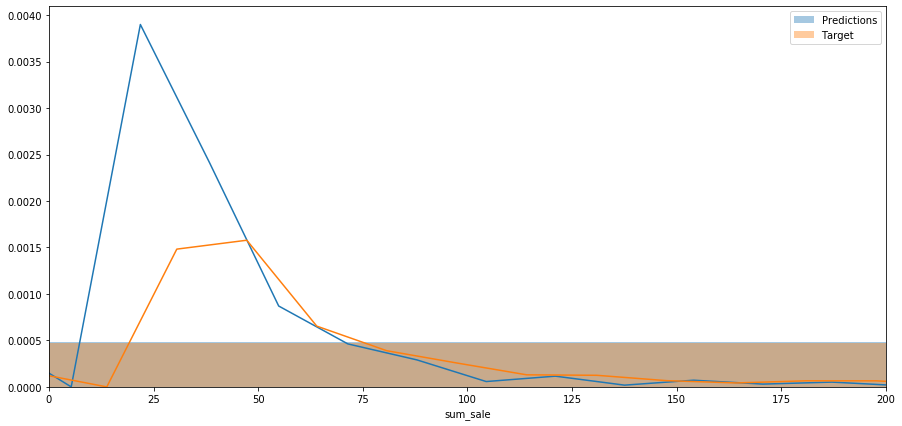

In [20]:
df2 = df1.query('promo_groups_cat == 12')
axes =  plt.subplots(figsize= (15 , 7 )) 
z = sns.distplot(df2['Predictions'],  bins = 1, label='Predictions')
z = sns.distplot(df2['sum_sale'], bins = 1, label='Target')
z.set(xlim=(0,200))
plt.legend()

Модель склонна чаще предсказывать небольшие продажи на промо, чем большие. Также посмотрим на распределение продаж в этой группе:

[(0, 200)]

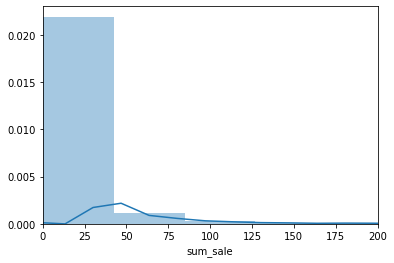

In [21]:
df3 = df.query('promo_groups_cat == 12')
z = sns.distplot(df3['sum_sale'])
z.set(xlim=(0,200))

В этой группе преобладают товары с продажами до 40 штук по промо - очевидно, предсказывать огромные продажи алгоритму сложнее. Давайте взглянем в целом на распределение количества продаж по датасету

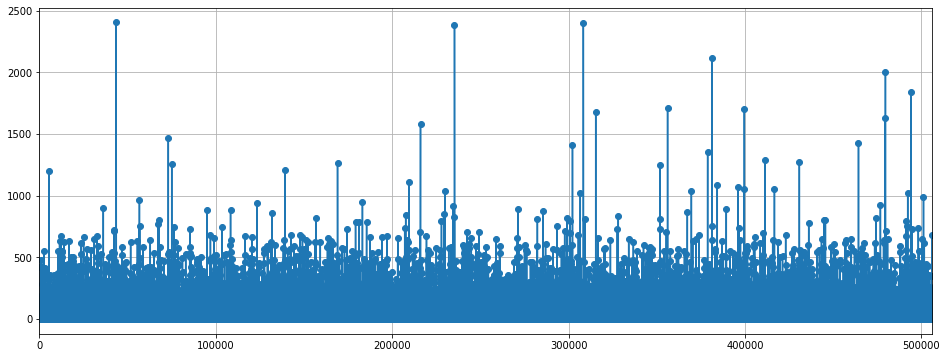

In [22]:
df['sum_sale'].plot(style='o-', grid=True,figsize=(16, 6))

Основная масса продаж - до 500 штук в промо. Продажи больше этого количества редки. Отсюда первое предложение по улучшению качества прогноза - попробовать побороться с дисбалансом, добавив больше данных о крупных продажах в промо.
Проведем примитивный небольшой эксперимент с увеличением выборки.

In [23]:
for_up = train.query('sum_sale > 500')
for_up.shape[0]

291

In [24]:
train  = train.append(for_up * 10)

f_train = train.drop('sum_sale',axis=1)
t_train = train['sum_sale']

f_train, f_valid, t_train, t_valid = train_test_split(f_train, t_train, test_size=0.2, random_state=1)

model_cb = CatBoostRegressor(learning_rate = 0.1, depth= 10,  n_estimators = 500, l2_leaf_reg = 0.1, eval_metric = 'MAE', verbose = True)
model_cb.fit(f_train, t_train)
predictions_cb_test = model_cb.predict(f_test)
mae_cb_test = mean_absolute_error(t_test, predictions_cb_test)
mae_cb_test

0:	learn: 19.3609739	total: 188ms	remaining: 1m 33s
1:	learn: 18.3350611	total: 426ms	remaining: 1m 46s
2:	learn: 17.3738798	total: 625ms	remaining: 1m 43s
3:	learn: 16.7477488	total: 896ms	remaining: 1m 51s
4:	learn: 16.0006681	total: 1.09s	remaining: 1m 47s
5:	learn: 15.4057411	total: 1.32s	remaining: 1m 49s
6:	learn: 14.8397558	total: 1.51s	remaining: 1m 46s
7:	learn: 14.2802907	total: 1.71s	remaining: 1m 45s
8:	learn: 13.9731708	total: 1.91s	remaining: 1m 44s
9:	learn: 13.5505859	total: 2.13s	remaining: 1m 44s
10:	learn: 13.1156522	total: 2.37s	remaining: 1m 45s
11:	learn: 12.7771118	total: 2.59s	remaining: 1m 45s
12:	learn: 12.5249242	total: 2.77s	remaining: 1m 43s
13:	learn: 12.2192929	total: 2.97s	remaining: 1m 43s
14:	learn: 11.9886872	total: 3.16s	remaining: 1m 42s
15:	learn: 11.7875839	total: 3.38s	remaining: 1m 42s
16:	learn: 11.6475811	total: 3.56s	remaining: 1m 41s
17:	learn: 11.5068965	total: 3.77s	remaining: 1m 40s
18:	learn: 11.2896974	total: 3.95s	remaining: 1m 39s
19:

157:	learn: 7.0890150	total: 31s	remaining: 1m 7s
158:	learn: 7.0764120	total: 31.2s	remaining: 1m 6s
159:	learn: 7.0631529	total: 31.4s	remaining: 1m 6s
160:	learn: 7.0606148	total: 31.5s	remaining: 1m 6s
161:	learn: 7.0522089	total: 31.7s	remaining: 1m 6s
162:	learn: 7.0382192	total: 31.9s	remaining: 1m 6s
163:	learn: 7.0284079	total: 32.1s	remaining: 1m 5s
164:	learn: 7.0154438	total: 32.3s	remaining: 1m 5s
165:	learn: 7.0127472	total: 32.5s	remaining: 1m 5s
166:	learn: 7.0115296	total: 32.7s	remaining: 1m 5s
167:	learn: 7.0098729	total: 32.9s	remaining: 1m 4s
168:	learn: 7.0009831	total: 33.1s	remaining: 1m 4s
169:	learn: 6.9898852	total: 33.3s	remaining: 1m 4s
170:	learn: 6.9770176	total: 33.4s	remaining: 1m 4s
171:	learn: 6.9665100	total: 33.6s	remaining: 1m 4s
172:	learn: 6.9644325	total: 33.8s	remaining: 1m 3s
173:	learn: 6.9631648	total: 34s	remaining: 1m 3s
174:	learn: 6.9563401	total: 34.2s	remaining: 1m 3s
175:	learn: 6.9507854	total: 34.4s	remaining: 1m 3s
176:	learn: 6.94

316:	learn: 6.2734610	total: 1m 10s	remaining: 40.6s
317:	learn: 6.2698799	total: 1m 10s	remaining: 40.4s
318:	learn: 6.2612179	total: 1m 10s	remaining: 40.2s
319:	learn: 6.2587457	total: 1m 11s	remaining: 40s
320:	learn: 6.2548758	total: 1m 11s	remaining: 39.8s
321:	learn: 6.2468141	total: 1m 11s	remaining: 39.6s
322:	learn: 6.2427369	total: 1m 11s	remaining: 39.4s
323:	learn: 6.2400264	total: 1m 12s	remaining: 39.2s
324:	learn: 6.2377212	total: 1m 12s	remaining: 39s
325:	learn: 6.2325723	total: 1m 12s	remaining: 38.9s
326:	learn: 6.2313819	total: 1m 13s	remaining: 38.7s
327:	learn: 6.2281517	total: 1m 13s	remaining: 38.5s
328:	learn: 6.2261041	total: 1m 13s	remaining: 38.3s
329:	learn: 6.2195540	total: 1m 13s	remaining: 38.1s
330:	learn: 6.2186302	total: 1m 14s	remaining: 37.9s
331:	learn: 6.2139132	total: 1m 14s	remaining: 37.7s
332:	learn: 6.2081079	total: 1m 14s	remaining: 37.6s
333:	learn: 6.2047351	total: 1m 15s	remaining: 37.5s
334:	learn: 6.1980057	total: 1m 15s	remaining: 37.

472:	learn: 5.8081616	total: 1m 50s	remaining: 6.3s
473:	learn: 5.8056600	total: 1m 50s	remaining: 6.07s
474:	learn: 5.8023622	total: 1m 50s	remaining: 5.84s
475:	learn: 5.7999177	total: 1m 51s	remaining: 5.6s
476:	learn: 5.7958305	total: 1m 51s	remaining: 5.37s
477:	learn: 5.7935446	total: 1m 51s	remaining: 5.13s
478:	learn: 5.7877205	total: 1m 51s	remaining: 4.9s
479:	learn: 5.7847324	total: 1m 52s	remaining: 4.67s
480:	learn: 5.7821211	total: 1m 52s	remaining: 4.43s
481:	learn: 5.7767615	total: 1m 52s	remaining: 4.2s
482:	learn: 5.7749111	total: 1m 52s	remaining: 3.96s
483:	learn: 5.7708784	total: 1m 52s	remaining: 3.73s
484:	learn: 5.7703337	total: 1m 53s	remaining: 3.5s
485:	learn: 5.7692989	total: 1m 53s	remaining: 3.26s
486:	learn: 5.7674092	total: 1m 53s	remaining: 3.03s
487:	learn: 5.7648518	total: 1m 53s	remaining: 2.8s
488:	learn: 5.7623035	total: 1m 54s	remaining: 2.56s
489:	learn: 5.7603011	total: 1m 54s	remaining: 2.33s
490:	learn: 5.7597856	total: 1m 54s	remaining: 2.1s


8.098413219637205

Есть небольшой прирост качества по сравнению с результатами прошлого обучения. Можно попробовать экспериментировать в этом направлении.

Следующее предложение по улучшению - изучить подробнее возможные аномалии. Рассмотрим боксплоты и описание данных:

For discount
count    506242.000000
mean         26.184155
std          11.061718
min           0.000000
25%          20.000000
50%          25.000000
75%          33.000000
max          90.000000
Name: discount, dtype: float64


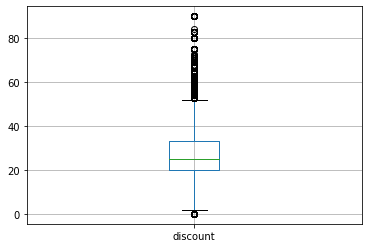

For avg_presale
count    506242.000000
mean          0.158427
std           0.544319
min           0.000000
25%           0.000000
50%           0.031200
75%           0.125000
max          47.343700
Name: avg_presale, dtype: float64


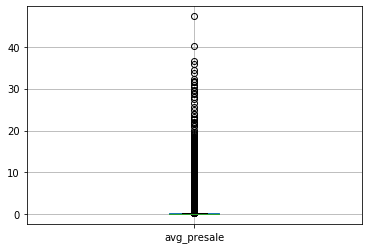

For sum_presale
count    506242.000000
mean          4.526260
std          16.357918
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        1515.000000
Name: sum_presale, dtype: float64


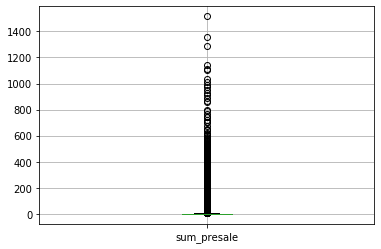

For max_presale
count    506242.000000
mean          1.156226
std           2.466288
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max         207.000000
Name: max_presale, dtype: float64


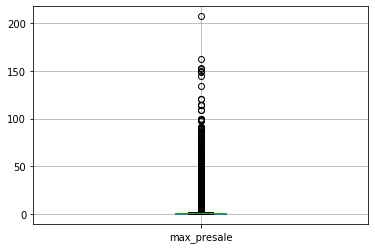

For min_presale
count    506242.000000
mean          0.006876
std           0.128699
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: min_presale, dtype: float64


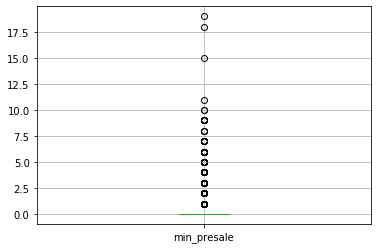

For reg_price
count    506242.000000
mean       6052.734117
std        9203.902569
min          19.000000
25%         899.000000
50%        2599.000000
75%        7199.000000
max      139990.000000
Name: reg_price, dtype: float64


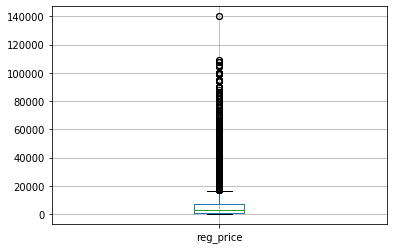

For promo_price
count    506242.000000
mean       4600.031929
std        6925.529878
min          19.000000
25%         599.000000
50%        1899.000000
75%        5599.000000
max      111999.000000
Name: promo_price, dtype: float64


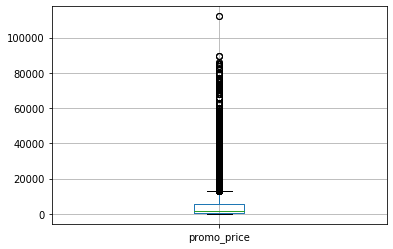

In [25]:

for value in ['discount', 'avg_presale', 'sum_presale', 'max_presale', 'min_presale', 'reg_price', 'promo_price']:
    print('For',value)
    df.boxplot(value)
    print(df[value].describe())
    plt.show()

У avg_presale слишком малые значения, и поэтом большинство значений, отличных от 0 могут восприниматься за выбросы. Подобная ситуация и с sum_presale, max_presale, min_presale - хотя эти данные вполне могут говорить о том, что акции идут в основном на товары, которые продаются очень плохо в предшествующий промо период (или не продаются совсем). Ситуация с reg_price и promo_price похожа -  данные смещены влево,это видно по 75% квантилю: основна часть данные находится до него.

Сложно здесь посоветовать что-либо конкретное, так как это распределение может быть и нормальной ситуацией для бизнеса. Я бы, возвращаяясь к первому совету, попыталась сбалансировать данные и проверять гипотезы о нормальности отдельных событий.

Последний совет связан с конструированием признаков. Посмотрим на график взаимосвязи данных:

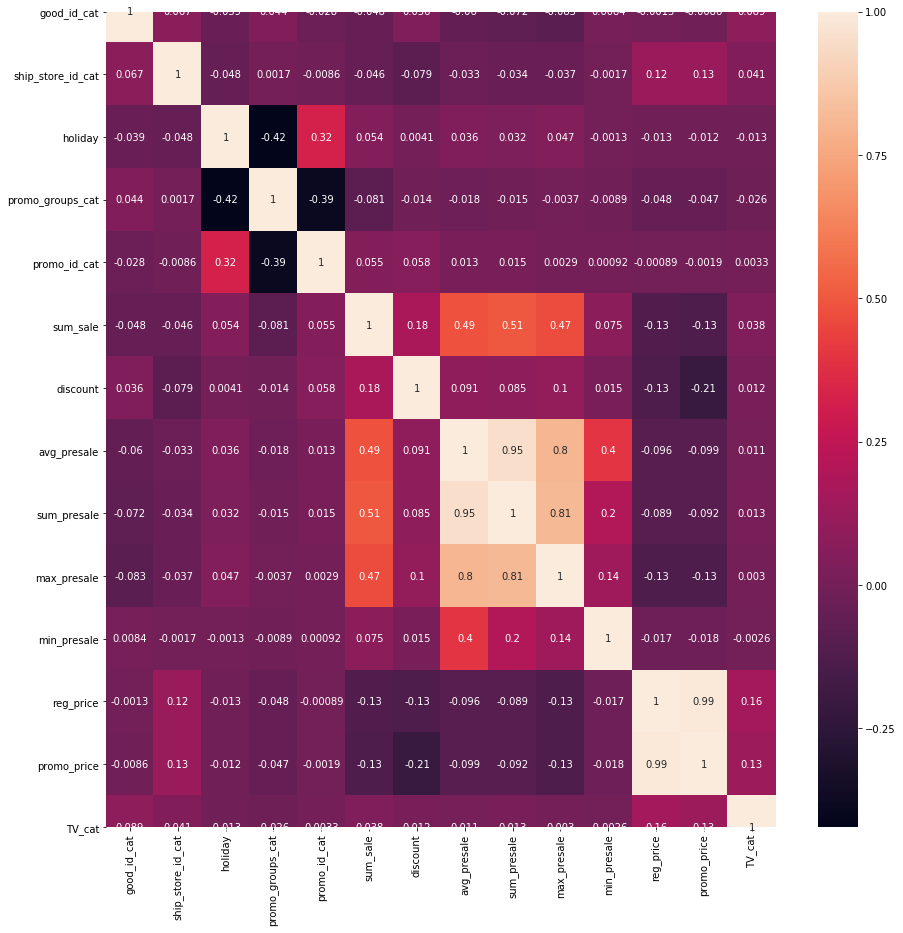

In [26]:
corrMatrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=True)

Не так много признаков коррелируют с таргетом. Хоть корреляция может быть и не прямой, по графику очевидно, что модель ориентируется на данные по периоду до промо. Я бы посоветовала подумать над констурированием признаков, которые сделают предсказания более устойчивыми.